In [92]:
# We import some custom functions
from custom_functions import *

# We import the libraries
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
df_original = pd.read_csv('sales_train.csv')

In [3]:
df_original.shape

(2935849, 6)

In [4]:
df_original.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Merges

To recover all the useful information, we merge the fact table **sales_train** with the other dimensions

In [5]:
# We read all the dataframes
df_sales = df_original.copy()

In [6]:
df_shops = pd.read_csv('shops.csv')
df_categories = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')

In [7]:
# We join the information between the categories and the items
df_categories_items = df_categories.merge(df_items, how='left', left_on='item_category_id', right_on='item_category_id')

In [8]:
# Firstly, we recover the information from the shops dimension, secondly from the categories and the items dimensions
df = df_sales.merge(df_shops, how='left', left_on='shop_id', right_on='shop_id')
df = df.merge(df_categories_items, how='left', left_on='item_id', right_on='item_id')

In [9]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,37,ЯВЛЕНИЕ 2012 (BD)
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",Музыка - Винил,58,DEEP PURPLE The House Of Blue Light LP
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",Музыка - Винил,58,DEEP PURPLE The House Of Blue Light LP
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",Музыка - Винил,58,DEEP PURPLE Who Do You Think We Are LP
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,56,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)


In [10]:
df = df.drop_duplicates()

In [11]:
df.shape

(2935843, 10)

Now that we have all the potential useful features for the fact table, we can start to explore it. Of course, we already observe that many descriptions are in Cyrillic, which is confusing

# Exploratory Data Analysis I (EDA I)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   shop_name           object 
 7   item_category_name  object 
 8   item_category_id    int64  
 9   item_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [13]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.93584e+06,2.93584e+06,2.93584e+06,2.93584e+06,2.93584e+06,2.93584e+06
mean,14.5699,33.0017,10197.2,890.853,1.24264,40.0014
std,9.42299,16.227,6324.29,1729.8,2.61884,17.1008
min,0,0,0,-1,-22,0
25%,7,22,4476,249,1,28
50%,14,31,9343,399,1,40
75%,23,47,15684,999,1,55
max,33,59,22169,307980,2169,83


We take a look at the date column according to the description of date_block_num that we found on the Kaggle webpage

In [14]:
df[df['date_block_num']==0]['date']

0         02.01.2013
1         03.01.2013
2         05.01.2013
3         06.01.2013
4         15.01.2013
             ...    
115685    19.01.2013
115686    18.01.2013
115687    26.01.2013
115688    31.01.2013
115689    07.01.2013
Name: date, Length: 115689, dtype: object

In [15]:
df[df['date_block_num']==33]['date']

2882335    23.10.2015
2882336    05.10.2015
2882337    02.10.2015
2882338    12.10.2015
2882339    04.10.2015
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 53514, dtype: object

We also take a look at the item_price

In [16]:
len(df[df['item_price']==-1])

1

In [17]:
value_counts_csv(df)

In [18]:
count_nulls(df)

In [19]:
cols_names = [col for col in df.columns if col not in ['shop_name', 'item_name', 'item_category_name']]
hist_boxplot(df[cols_names])

## - First Remarks and ideas for each column: individual features

- First of all, there are **no null values** in this dataset

- **date**: 34 consecutive possible months for each item. The minimum (month, year) is Octuber 2013 and the maximum is Octuber 2015.
- **date_block_num**: minimum is 0 and maximum 33. By the definition of this column, this is strictly connected to the date column. We observe that for each value we can have a minimum of 50k items and a maximum of 143k
- **shop_id**: there are 60 different shops with sales data. We observe that the number of observations per shop goes from 0.3k to 235k. This suggests that some particular shops are able to manage many products (maybe they are bigger shops actually)
- **item_id**: we have 21807 different items. We observe that the item_id 20949 is more popular than the others by far. It is about the 1% of our observations
- **item_price**: for sure, looking at the boxplot, it is evident that there are some outliers. Indeed the mean which is 890 is very different from the median (390) and moreover the maximum value is bigger than 300k. There is also an observation with price equal to -1 
- **item_cnt_day**: almost the 90% of our observations has item_cnt_day equal to 1. Looking at the charts, we see that we have a lot of outliers and some negative values
- **item_category_id**: we have 84 distinct categories. Among them, there are three much more popular than the others. The category_id 40 has almost the 20% of the total observations. 
- **shop_name**: all the names are in Cyrillic. We could think of translating them to English to get some insights. We have the feeling that the name of the shop always contains the name of the city
- **item_name**: many names are in Cyrillic. Also in this case, we could think of translating them to English to get some insights

# Feature Engineering I

In [20]:
# item_price with negative values
df[df['item_price']<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
484683,15.05.2013,4,32,2973,-1.0,1.0,"Москва ТЦ ""Серебряный Дом""",Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]"


- Luckily, it is just one raw in the entire dataset. Clearly it is an error due to the registration of the price on that day. We take a look at the prices for this item during other days in the same shop

In [21]:
df[(df['item_id']==2973) & (df['shop_id']==32) & (df['item_price']>0)][['item_price', 'date']]

,item_price,date
67427,2499.0,29.01.2013
67428,2499.0,25.01.2013
67429,2499.0,22.01.2013
67430,2499.0,21.01.2013
67431,2499.0,18.01.2013
67432,2499.0,17.01.2013
67433,2499.0,15.01.2013
187844,2499.0,05.02.2013
187845,2499.0,14.02.2013
484682,1249.0,23.05.2013


- Only in two obcasions that price has been cutted at the half, probably for a special 50% discount
- Since a discount like this seems to be as something very rare and special, we decide to replace the negative value with the full price

In [22]:
df['item_price'] = np.where(df['item_price']==-1, 
                            2499.0, 
                            df['item_price'])

In [23]:
# item_price with outlier > 300k
df[df['item_price']>300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
1163158,13.12.2013,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Программы - Для дома и офиса,75,Radmin 3 - 522 лиц.


In [24]:
df[(df['item_id']==6066) & (df['shop_id']==12) & (df['item_price']<300000)][['item_price', 'date']]

,item_price,date


In [25]:
df[(df['item_id']==6066) & (df['item_price']<300000)][['item_price', 'date']]

,item_price,date


- This item has been sold in one shop only once with a price that seems to be not reasonable
- Therefore, we proceed to eliminate this row from the dataset

In [26]:
df = df[df['item_id'] != 6066]

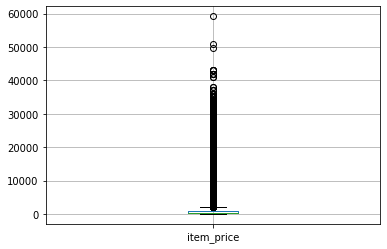

In [27]:
df.boxplot(column='item_price')

In [28]:
df[df['item_price']>45000]['item_price'].value_counts().sort_index(ascending=False)

59200.0    1
50999.0    1
49782.0    1
Name: item_price, dtype: int64

- Looking at the boxplot, we can deduce that there are 3 isolated outliers above 45k. It seems like they do not represent the real price strategy of the company that we are analizing. Probably someone made a mistake registering that price or it is a strange product with a very flexible range price
- Therefore, without additional information, we decide to eliminate them

In [29]:
df = df[df['item_price']<=45000]

In [30]:
df.shape

(2935839, 10)

In [31]:
# item_cnt_day negative
df[df['item_cnt_day']<0]['item_cnt_day'].value_counts()

-1.0     7252
-2.0       78
-3.0       14
-5.0        4
-4.0        3
-6.0        2
-9.0        1
-16.0       1
-22.0       1
Name: item_cnt_day, dtype: int64

- We interpret the negative values in item_cnt_day as the number of returned copies for that specific item, in that specific shop and on that specific day 
- According to this, we decide to keep those values and not to treat them as outliers. The monthly amount of sold copies for a particular item will be the algebraic sum of item_cnt_day

In [32]:
# item_cnt_day outliers
df[df['item_cnt_day']>900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name
2326930,15.01.2015,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...
2909818,28.10.2015,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка товара,9,Доставка до пункта выдачи (Boxberry)


- Looking at the boxplot, we observe that there are two values above 1000 of item_cnt_day that are isolated. 
- We took the corresponing item_name and using Google translate we found the following meanings: "Фирменный пакет майка 1С Интерес белый" means "Corporate package T-shirt 1C Interest white" and "Доставка товара" means "delivery of goods"
- This gives us an idea that these rows represent very particular orders during some particular events
- Therefore, we decide to eliminate them

In [33]:
df = df[df['item_cnt_day']<=900]

- Finally, we observe that the first word before either "-" or a white space or a "!" in the shop_name column represents the name of a city.
- Because of this, we create a column city

In [34]:
df['city'] = df['shop_name'].str.split(" ").str[0]
df['city'] = df['city'].str.split("-").str[0]
df['city'] = df['city'].str.split("!").str[-1]

In [35]:
# We check the names of the cities
df['city'].value_counts()

Москва          996633
Якутск          204404
СПб             148534
Воронеж         144151
Химки           143479
Тюмень          125453
Уфа              96423
Красноярск       76177
Самара           75421
Чехов            69573
Сергиев          66321
Н.Новгород       64197
Курск            63911
РостовНаДону     59664
Калуга           59511
Сургут           56695
Казань           54803
Коломна          52734
Омск             46013
Ярославль        42108
Новосибирск      39944
Волжский         38242
Вологда          38179
Цифровой         34769
Интернет         34689
Адыгея           25991
Балашиха         25532
Жуковский        21896
Томск            21612
Мытищи            5027
Выездная          3751
Name: city, dtype: int64

# EDA II: Study of the pairs (shop_id, item_id)

- We check if all the pairs (shop_id, item_id) that we have on the test.csv actually exist in our dataframe and if also the converse is true or not

In [36]:
df_test = pd.read_csv('test.csv')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [37]:
df_test = df_test[['shop_id', 'item_id']]

In [38]:
df_test['joined_fields'] = df_test['shop_id'].astype(str) + "_" + df_test['item_id'].astype(str)

In [39]:
df['joined_fields'] = df['shop_id'].astype(str) + "_" + df['item_id'].astype(str)

In [40]:
df_values = set(df['joined_fields'])
df_test['Match'] = df_test['joined_fields'].isin(df_values)

In [41]:
df_test['Match'].value_counts()

True     111404
False    102796
Name: Match, dtype: int64

- So actually we will need to predict item_cnt_day for a lot of pairs (shop_id, item_id) that our model will see for the first time

In [42]:
df_test.head()

,shop_id,item_id,joined_fields,Match
0,5,5037,5_5037,True
1,5,5320,5_5320,False
2,5,5233,5_5233,True
3,5,5232,5_5232,True
4,5,5268,5_5268,False


In [43]:
df[(df['shop_id']==5) & (df['item_id']==5320)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_category_name,item_category_id,item_name,city,joined_fields


In [44]:
df_test_values = set(df_test['joined_fields'])
df['Match'] = df['joined_fields'].isin(df_values)

In [45]:
df['Match'].value_counts()

True    2935837
Name: Match, dtype: int64

In [46]:
df.drop('Match', axis = 1, inplace=True)

# EDA III: Feature relations

In [47]:
df['month'] = df['date'].str.split(".").str[1]
df['year'] = df['date'].str.split(".").str[2]
df.drop('date', axis=1, inplace=True)

In [48]:
agg_dict = {'item_cnt_day': 'sum', 'item_price': np.median}

cols_to_exclude = ['item_price', 'item_cnt_day']
df = df.groupby([x for x in df.columns.tolist() if x not in cols_to_exclude], as_index=False).agg(agg_dict)

df.head()

,date_block_num,shop_id,item_id,shop_name,item_category_name,item_category_id,item_name,city,joined_fields,month,year,item_cnt_day,item_price
0,0,0,32,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,1+1,Якутск,0_32,01,2013,6.0,221.0
1,0,0,33,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,37,1+1 (BD),Якутск,0_33,01,2013,3.0,347.0
2,0,0,35,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,10 ЛЕТ СПУСТЯ,Якутск,0_35,01,2013,1.0,247.0
3,0,0,43,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,100 МИЛЛИОНОВ ЕВРО,Якутск,0_43,01,2013,1.0,221.0
4,0,0,51,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3,57,100 лучших произведений классики (mp3-CD) (Dig...,Якутск,0_51,01,2013,2.0,128.5


In [49]:
df.drop(['month', 'year'], axis=1, inplace=True)

# Feature Engineering II

If an item does not appear in a shop druing a month, we create a new observation filling that row with item_cnt_day equal to 0 and item_price equal to the price of the month before

In [50]:
#df['month_year'] = df['year'] + "-" + df['month']
cols_to_exclude = ['item_price', 'month', 'year', 'date_block_num', 'item_cnt_day']

df_pivoted_stacked = df.drop(['item_price'], axis=1).pivot_table(["item_cnt_day"], [x for x in df.columns.tolist() if x not in cols_to_exclude], 'date_block_num').stack(1, dropna=False)

df_pivoted_stacked = df_pivoted_stacked.reset_index()

df_pivoted_stacked.head(10)

df_merged = df_pivoted_stacked.merge(df, on=df_pivoted_stacked.columns.tolist(), how='left')

df_merged.head(10)

med = df_merged.groupby('joined_fields')['item_price'].transform('median')

med

df_merged.shape

df_merged['item_price'].fillna(med, inplace=True)

df_merged.head()

df_merged['item_cnt_day'].fillna(0, inplace=True)

In [51]:
df_merged.head(10)

,shop_id,item_id,shop_name,item_category_name,item_category_id,item_name,city,joined_fields,date_block_num,item_cnt_day,item_price
0,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,0,0.0,265.0
1,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,1,31.0,265.0
2,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,2,0.0,265.0
3,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,3,0.0,265.0
4,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,4,0.0,265.0
5,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,5,0.0,265.0
6,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,6,0.0,265.0
7,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,7,0.0,265.0
8,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,8,0.0,265.0
9,0,30,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,40,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Якутск,0_30,9,0.0,265.0


- For every (item, shop) we inserted a row for every month in case it was absent. The item_price has been filled with median and item_cnt_day with 0

## Strategy I: Benchmark

In [ ]:
df_predicted = df_merged[['joined_fields', 'date_block_num', 'item_cnt_day']]
df_predicted = df_predicted[df_predicted['date_block_num'] == 32]

In [ ]:
df_true_value = df_merged[['joined_fields', 'date_block_num', 'item_cnt_day']]
df_true_value = df_true_value[df_true_value['date_block_num'] == 33]

In [ ]:
df_benchmark = df_predicted.merge(df_true_value, on='joined_fields', how='inner', suffixes=['_predicted','_true_value'])

In [ ]:
df_benchmark.head()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Now we evaluate the benchmark prediction
r2_score(df_benchmark['item_cnt_day_predicted'], df_benchmark['item_cnt_day_true_value'])

In [ ]:
mean_squared_error(df_benchmark['item_cnt_day_predicted'], df_benchmark['item_cnt_day_true_value'])

In [ ]:
mean_squared_error(df_benchmark['item_cnt_day_predicted'], df_benchmark['item_cnt_day_true_value']) ** 0.5

- We observe that the r2 score is extremely low
- the RMSE on the other hand is quite acceptable

In [ ]:
import matplotlib.pyplot as plt
error_benchmark = df_benchmark['item_cnt_day_predicted'] - df_benchmark['item_cnt_day_true_value']

In [ ]:
plt.hist(error_benchmark)

- most of the errors are around 0, which is good. However, we are also skewed towards right
- maybe in general people spend more money on September than October?

In [ ]:
plt.hist(error_benchmark[abs(error_benchmark)<10], bins=50)

In [ ]:
plt.scatter(df_benchmark['item_cnt_day_true_value'], df_benchmark['item_cnt_day_predicted'] - df_benchmark['item_cnt_day_true_value'])

In [ ]:
# count of errors in percentages
perc_errors_benchmark = abs(error_benchmark).value_counts().to_frame()
perc_errors_benchmark['value'] = perc_errors_benchmark.index
perc_errors_benchmark = perc_errors_benchmark.sort_values(by=['value'])
perc_errors_benchmark['percentage'] = perc_errors_benchmark[0] / sum(perc_errors_benchmark[0])
perc_errors_benchmark['cumsum'] = perc_errors_benchmark[0].cumsum()
perc_errors_benchmark['percentage_comulative'] = perc_errors_benchmark['cumsum'] / sum(perc_errors_benchmark[0])

In [ ]:
perc_errors_benchmark

 - From this table we deduce that in about 90% of our cases we predict the correct value
 - In 99%, the error is lower than 3
 - we need to investigate if the 0 errors correspond 0 values

In [ ]:
df_benchmark['error'] = error_benchmark
df_benchmark_zero_error = df_benchmark[df_benchmark['error'] == 0]

In [ ]:
df_benchmark_zero_error['item_cnt_day_true_value'].value_counts()

- We observe that most of the true values are 0. This means that these items were not sold in the last month we were considering, so probably our predictions are not so meaningful

# Statistical Strategy: ARIMA

In [ ]:
df_arima = df_merged.copy()
df_arima_joined = df_arima.drop(['shop_id', 'item_id', 'shop_name', 'item_category_name', 'item_category_id', 'item_name', 'city', 'item_price'], axis=1)

In [ ]:
df_arima_joined.head()

- Let's look for some seasonality in our data at the level of the pairs (shop_id, item_id)

In [ ]:
example = df_arima_joined['joined_fields'].sample(n = 30, random_state = 234)

fig, axs = plt.subplots(30, figsize = (20,80))

for i in range(0,30):
    j = example.iloc[i]
    df_example = df_arima_joined[df_arima_joined['joined_fields'] == j]
    axs[i].plot(df_example['date_block_num'], df_example['item_cnt_day'])
    axs[i].set_xticks(range(0, 34))

- We have a lot of 0 values that do not permit find some seasonality traits. Let's look for some seasonality at the shop level

In [ ]:
df_arima_shop_item = df_merged.drop(['joined_fields', 'item_id', 'shop_name', 'item_category_name', 'item_category_id', 'item_name', 'city', 'item_price'], axis=1)
df_arima_shop_item = df_arima_shop_item.groupby(["date_block_num", "shop_id"], as_index=False).agg({"item_cnt_day": sum})
example = df_arima_shop_item['shop_id'].sample(n = 30, random_state = 234)

fig, axs = plt.subplots(30, figsize = (20,80))

for i in range(0,30):
    j = example.iloc[i]
    df_example = df_arima_shop_item[df_arima_shop_item['shop_id'] == j]
    axs[i].plot(df_example['date_block_num'], df_example['item_cnt_day'])
    axs[i].set_xticks(range(0, 34))

- In this case we notice some seasonalities. For example, we have some peaks in December, which is quite reasonable
- Let's try to plot some items that do not have any zeros

In [ ]:
df_no_zero = df_merged.copy()
df_no_zero['sold'] = np.where(df_no_zero['item_cnt_day']>= 1,1,0) 
always_sold = df_no_zero[['joined_fields', 'sold']].groupby(["joined_fields"], as_index=False). agg({"sold" :sum })
always_sold = always_sold[always_sold['sold'] >= 34]

example2 = always_sold['joined_fields'] .sample(n = 30, random_state = 234)

fig, axs = plt.subplots(30, figsize = (20,80))

for i in range(0,30):
    j = example2.iloc[i]
    df_example = df_merged[df_merged['joined_fields'] == j]
    axs[i].plot(df_example['date_block_num'], df_example['item_cnt_day'])
    axs[i].set_xticks(range(0, 34))

- Also in this case we can see some seasonalities but they do not seem as clear as in the previous case
- We decide to try ARIMA anyway

## Strategy IIa: XGBoost I

In [ ]:
df_pivot = df_merged.copy()
med = df_pivot.groupby('joined_fields')['item_price'].transform('median')
df_pivot['median_price'] = med

In [ ]:
df_pivot.head()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_pivot['city'])
city_numeric = le.transform(df_pivot['city'])

In [ ]:
df_pivot['city'] = city_numeric

In [ ]:
df_pivot = df_pivot.drop(['shop_name', 'item_category_name', 'item_name', 'item_price'], axis=1)
cols_to_exclude = ['item_cnt_day', 'date_block_num']

In [ ]:
df_pivot_2 = df_pivot.copy()
df_pivot_2 = df_pivot_2.pivot_table(values='item_cnt_day', index=[x for x in df_pivot.columns if x not in cols_to_exclude], columns='date_block_num').reset_index()
df_pivot_2 = df_pivot_2.rename_axis(None, axis=1)
df_pivot_2.head()

In [ ]:
df_xgb = df_pivot_2.copy()

In [ ]:
df_xgb.columns = df_xgb.columns.astype(str)

In [ ]:
X = df_xgb.drop(['joined_fields', '33'], axis=1).copy()
y = df_xgb['33'].values

# Splitting into train and test
# It returns dataframes with proper indices
# Observe that X_train_orig will contain a copy of y

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, 
                                                                        shuffle=True, random_state=345)

In [ ]:
import xgboost as xgb
xgb_model_default = regressor_gridCV(X_train_orig, y_train_orig, xgb.XGBRegressor(),
                                     X_test_orig, y_test_orig, model_name = "xg_boost")

In [ ]:
import pickle

# We save xgb_model_default to our directory
filename = "Models/CV_results/default_models/xgb_model_default.sav"
pickle.dump(xgb_model_default, open(filename, 'wb'))

- For sure the XGBoost strategy outperformed by far the Benchmark strategy
- 

# Strategy IIb: XGBoost II

In [52]:
df_xgb_2 = df_merged.copy()

In [53]:
df_xgb_2.drop(['shop_name', 'item_category_name', 'item_name'], axis=1, inplace=True)

In [54]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_xgb_2['city'])
city_numeric = le.transform(df_xgb_2['city'])
df_xgb_2['city'] = city_numeric
df_xgb_lag = df_xgb_2.copy()
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price
0,0,30,40,29,0_30,0,0.0,265.0
1,0,30,40,29,0_30,1,31.0,265.0
2,0,30,40,29,0_30,2,0.0,265.0
3,0,30,40,29,0_30,3,0.0,265.0
4,0,30,40,29,0_30,4,0.0,265.0


In [55]:
for i in range(1, 13):
    df_to_merge = df_xgb_2.copy()
    df_to_merge['date_block_num'] = df_to_merge['date_block_num'] + i
    df_to_merge['item_cnt_day_lag_' + str(i)] = df_to_merge['item_cnt_day']
    df_xgb_lag = df_xgb_lag.merge(df_to_merge[['item_cnt_day_lag_' + str(i), 'date_block_num', 'joined_fields']], 
                                left_on=['date_block_num', 'joined_fields'],
                                right_on=['date_block_num', 'joined_fields'],
                                how='left', suffixes=(None, None))
    

In [56]:
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_cnt_day_lag_5,item_cnt_day_lag_6,item_cnt_day_lag_7,item_cnt_day_lag_8,item_cnt_day_lag_9,item_cnt_day_lag_10,item_cnt_day_lag_11,item_cnt_day_lag_12
0,0,30,40,29,0_30,0,0.0,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,30,40,29,0_30,1,31.0,265.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,30,40,29,0_30,2,0.0,265.0,31.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,30,40,29,0_30,3,0.0,265.0,0.0,31.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,30,40,29,0_30,4,0.0,265.0,0.0,0.0,31.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df_xgb_lag.shape

(14420114, 20)

- We get rid of the null values in **item_cnt_day_lag_x** columns

In [58]:
df_xgb_lag = df_xgb_lag[df_xgb_lag['item_cnt_day_lag_12'].notna()]

In [59]:
df_xgb_lag.shape

(9330662, 20)

In [60]:
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_cnt_day_lag_5,item_cnt_day_lag_6,item_cnt_day_lag_7,item_cnt_day_lag_8,item_cnt_day_lag_9,item_cnt_day_lag_10,item_cnt_day_lag_11,item_cnt_day_lag_12
12,0,30,40,29,0_30,12,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0
13,0,30,40,29,0_30,13,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
14,0,30,40,29,0_30,14,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0,30,40,29,0_30,15,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0,30,40,29,0_30,16,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df_xgb_2.head()

,shop_id,item_id,item_category_id,city,joined_fields,date_block_num,item_cnt_day,item_price
0,0,30,40,29,0_30,0,0.0,265.0
1,0,30,40,29,0_30,1,31.0,265.0
2,0,30,40,29,0_30,2,0.0,265.0
3,0,30,40,29,0_30,3,0.0,265.0
4,0,30,40,29,0_30,4,0.0,265.0


- Now we insert as column the item_price related to the previous month

In [62]:
df_to_merge = df_xgb_2.copy()
df_to_merge['date_block_num'] = df_to_merge['date_block_num'] + 1
df_to_merge['item_price_lag_1'] = df_to_merge['item_price']
df_xgb_lag = df_xgb_lag.merge(df_to_merge[['item_price_lag_1', 'date_block_num', 'joined_fields']], 
                              left_on=['date_block_num', 'joined_fields'],
                              right_on=['date_block_num', 'joined_fields'],
                              how='left', suffixes=(None, None))

In [63]:
df_xgb_lag.drop(['item_price', 'joined_fields'], axis=1, inplace=True)

In [64]:
df_xgb_lag.head()

,shop_id,item_id,item_category_id,city,date_block_num,item_cnt_day,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_cnt_day_lag_5,item_cnt_day_lag_6,item_cnt_day_lag_7,item_cnt_day_lag_8,item_cnt_day_lag_9,item_cnt_day_lag_10,item_cnt_day_lag_11,item_cnt_day_lag_12,item_price_lag_1
0,0,30,40,29,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,265.0
1,0,30,40,29,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,265.0
2,0,30,40,29,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0
3,0,30,40,29,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0
4,0,30,40,29,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0


- Before applying the XGBoost model, we perform a a Features Importance phase using Random Forest

# Features Importance and Selection II

- Due to our computational resources, we take a modest subsample of our dataframe (only 30%). Since item_cnt_day has some members with only 1 representative, we cannot use a stratified method. We decide to proceed anyway using sample

In [80]:
df_xgb_lag_sampled = df_xgb_lag.sample(frac=0.05, random_state=123)
df_xgb_lag_sampled.shape

(466533, 19)

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [82]:
rfc_model = RandomForestRegressor(random_state=123)

z = df_xgb_lag_sampled.copy()
y = z['item_cnt_day']
X = z.drop('item_cnt_day', axis=1)

In [83]:
y

3304447    0.0
7660138    0.0
1366384    0.0
1709832    0.0
7278738    0.0
          ... 
7318843    0.0
6121707    0.0
2079077    0.0
315830     0.0
8164621    0.0
Name: item_cnt_day, Length: 466533, dtype: float64

In [97]:
rfecv = RFECV(estimator=rfc_model, step=2, cv=KFold(n_splits=2, random_state=123, shuffle=True), 
              scoring='neg_mean_squared_error', n_jobs = -1, verbose=1)

In [98]:
rfecv.fit(X, y)

Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.


RFECV(cv=KFold(n_splits=2, random_state=123, shuffle=True),
      estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=None,
                                      oob_score=False, random_state=123,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=2, verbose=1)

Optimal number of features : 6
Best features : Index(['item_id', 'date_block_num', 'item_cnt_day_lag_1', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_7', 'item_cnt_day_lag_12'],
      dtype='object')
Original features : Index(['shop_id', 'item_id', 'item_category_id', 'city', 'date_block_num',
       'item_cnt_day_lag_1', 'item_cnt_day_lag_2', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_4', 'item_cnt_day_lag_5', 'item_cnt_day_lag_6',
       'item_cnt_day_lag_7', 'item_cnt_day_lag_8', 'item_cnt_day_lag_9',
       'item_cnt_day_lag_10', 'item_cnt_day_lag_11', 'item_cnt_day_lag_12',
       'item_price_lag_1'],
      dtype='object')


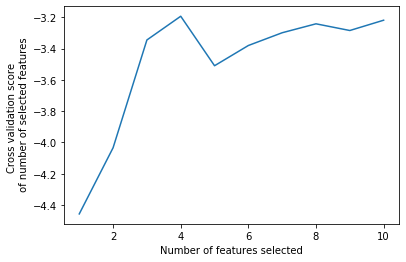

In [99]:
print("Optimal number of features : %d" % rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [100]:
print(rfecv.grid_scores_)
print(rfecv.ranking_)
print(rfecv.n_features_)
print(X.columns[rfecv.support_])
rfecv.estimator_.feature_importances_

[-4.45726619 -4.03420437 -3.34499195 -3.19328217 -3.50973636 -3.38033993
 -3.29880219 -3.24167012 -3.28449336 -3.21866431]
[4 1 5 4 1 1 2 1 5 6 2 1 3 7 7 6 1 3]
6
Index(['item_id', 'date_block_num', 'item_cnt_day_lag_1', 'item_cnt_day_lag_3',
       'item_cnt_day_lag_7', 'item_cnt_day_lag_12'],
      dtype='object')


array([0.15018611, 0.08485939, 0.18016362, 0.14377192, 0.16029711,
       0.28072185])

In [102]:
# We save rfecv to our directory
filename = "Models/features_importance/rfecv_xgb_2.sav"
pickle.dump(rfecv, open(filename, 'wb'))

In [121]:
num_feature = rfecv.n_features_
tab_general = pd.DataFrame ({ 'rank': rfecv.ranking_ , 'variables': X.columns.tolist()})
tab_rank = tab_general.copy()
tab_importances = tab_general.copy()

tab_rank = pd.DataFrame(tab_general.groupby('rank')['variables'].apply(list))
#tab_rank['score']= rfecv.grid_scores_[num_feature-1 : len(rfecv.grid_scores_)]

In [122]:
tab_rank

,variables
rank,
1,"[item_id, date_block_num, item_cnt_day_lag_1, ..."
2,"[item_cnt_day_lag_2, item_cnt_day_lag_6]"
3,"[item_cnt_day_lag_8, item_price_lag_1]"
4,"[shop_id, city]"
5,"[item_category_id, item_cnt_day_lag_4]"
6,"[item_cnt_day_lag_5, item_cnt_day_lag_11]"
7,"[item_cnt_day_lag_9, item_cnt_day_lag_10]"


In [123]:
tab_importances = tab_importances[tab_importances['rank']==1].drop('rank', axis = 1)
tab_importances['importances'] = rfecv.estimator_.feature_importances_
tab_importances.sort_values(by = 'importances', ascending = False, inplace = True)
tab_importances.reset_index(drop=True, inplace=True)

In [124]:
tab_importances

,variables,importances
0,item_cnt_day_lag_12,0.280722
1,item_cnt_day_lag_1,0.180164
2,item_cnt_day_lag_7,0.160297
3,item_id,0.150186
4,item_cnt_day_lag_3,0.143772
5,date_block_num,0.084859


# Strategies

- Benchmark
- xgboost
- statistical method

# next time
- interpretazioni outliers e negativi
- vedere se item id del test sono gli stessi del training
- aggruppare per shop, mese e rifare una analisi: quanti prodotti vendono, a che prezzo medio etc, quante categorie etc.
- aggruppare per shop, mese e item e fare feature engineering vera per il modello

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(df['shop_id'], '.')

In [ ]:
df.index

In [ ]:
plt.scatter(range(len(df['shop_id'])), df['shop_id']), c=df['item_cnt_day']

In [ ]:
plt.scatter(range(len(df['shop_id'])), df['shop_id'])